In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import 6

import SweetSpotPrediction as ssp

# Base Case read data

In [2]:
# File paths with corresponding map names
files_names = {'Data\\thickness\\thickness': 'Thickness'
         , 'Data\\avgntg\\avgntgasc': 'AvgNTG'
         , 'Data\\avgperm\\avgpermasc': 'AvgPerm'
         , 'Data\\avgporo\\avgporoasc': 'AvgPoro'
         , 'Data\\netperm\\netpermasc': 'NetPerm'
               
         , 'Data\\sweetspot.txt': 'SweetSpot'
              }

# Read map files
dfs = []
spacing = 50 # map grid cell dimension
for key in files_names:
    df = pd.read_csv(key, delimiter=' ', comment='#', names=['XPos', 'YPos', files_names[key], 'c1', 'c2'])
    df.drop(columns=['c1', 'c2'], inplace=True)
    df_reg = ssp.make_regular(df, files_names[key], spacing)
    df_reg.set_index(['XPos','YPos'], inplace=True)
    dfs = dfs + [df_reg]

# Merge dataframes
df = pd.concat(dfs, axis='columns', join='inner').reset_index()

In [3]:
features = [
    #'XPos', # propbably dont want these as features
    #'YPos', # propbably dont want these as features
    'Thickness',
    'AvgNTG',
    'AvgPerm',
    'AvgPoro',
    'NetPerm',

]

label_clf = 'SweetSpot' 

# Data cleaning

In [4]:
# Functions to drop values less than zero or greater than one

def drop_neg(x):
    if x < 0:
        return np.nan
    else:
        return x

def drop_gt1(x):
    if x > 1:
        return np.nan
    else:
        return x
    
def zero_to_one(x):
    if x < 0.2:
        return 0
    else:
        return 1

In [5]:
def clean_columns(df):

    # Clean dataframe according to specified columns to remove negatives or greater than one
    df_clean = df.copy()

    cols_remove_negs = set(df_clean.columns) - {'XPos', 'YPos', 'SweetSpot'}
    cols_remove_gt1 = {'AvgNTG', 'WellProbability'}
    cols_limit_zero_to_one = { 'SweetSpot'}


    for col in df_clean.columns:
        if col in cols_remove_negs:
            df_clean[col] = df_clean[col].apply(drop_neg)
        if col in cols_remove_gt1:
            df_clean[col] = df_clean[col].apply(drop_gt1)
        if col in cols_limit_zero_to_one:
            df_clean[col] = df_clean[col].apply(zero_to_one)
    df_clean.dropna(inplace=True)
    return df_clean

In [6]:
df_clean = clean_columns(df)

In [7]:
df_clean.SweetSpot = df_clean.SweetSpot.fillna(0).round().astype('int64')

# Goal: Sweet Spots 

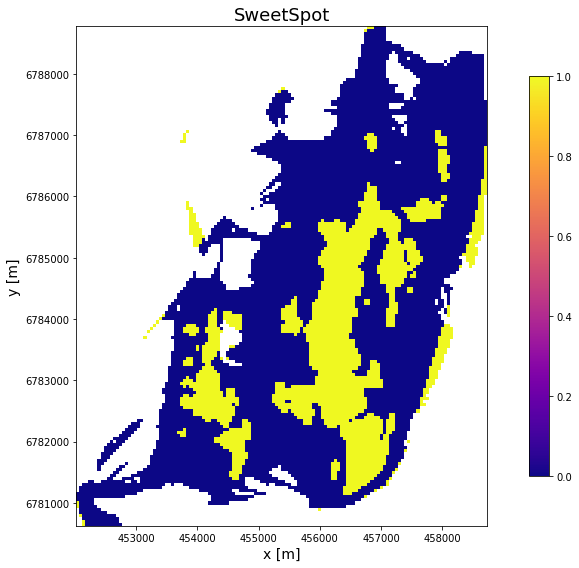

In [8]:
ssp.plot_map(df_clean, 'SweetSpot', dtype='cat')

# Split test data

In [9]:
#X_train, X_, y_train, y_ = train_test_split(df_clean[features], df_clean[label_clf], test_size=0.33, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.50, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(df_clean[features], df_clean[label_clf], test_size=0.33, random_state=42)


# Normalization and other preprocessing

In [10]:
preprocessing = StandardScaler()
X_train = preprocessing.fit_transform(X_train)

X_val = preprocessing.transform(X_val)

%store preprocessing
X_train[-5:]

Stored 'preprocessing' (StandardScaler)


array([[ 0.83425098,  0.04804986, -0.44612925, -0.17704471,  0.68491923],
       [ 0.8826881 ,  0.38672491, -0.05972242,  0.20507982,  1.29903083],
       [-1.19899854,  1.43542237,  0.25907509, -0.21902328, -0.27798813],
       [-0.41941127, -0.99709351, -0.27454254, -0.55117334, -0.80844015],
       [-1.50643828,  0.38038343, -0.68163865,  0.10243537, -1.03212434]])

# Train Model

In [11]:
from sklearn.naive_bayes import GaussianNB


#model = GaussianNB()
model = RandomForestClassifier(class_weight='balanced',n_estimators=200)
model.fit(X_train, y_train)

%store model

Stored 'model' (RandomForestClassifier)


# Model Scores

In [12]:
y_pred_val = model.predict(X_val)
ssp.ReportMetrics(model, X_train, X_val, y_train, y_val, y_pred_val)

Precision: 0.903
Recall: 0.806
F1: 0.852


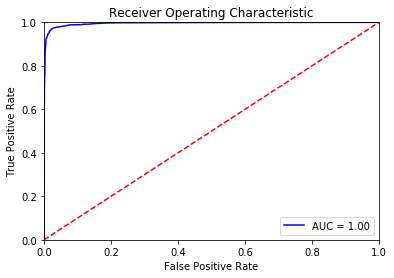

In [13]:
from sklearn.metrics import roc_curve, auc
df_clean['prediction_prob'] = model.predict_proba(preprocessing.transform(df_clean[features]))[:,1]

fpr, tpr, threshold = roc_curve(df_clean[label_clf], df_clean['prediction_prob'] )

roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Uncertainties

In [14]:
# number =1 will just return the base case property
def GenerateUncertainList(df, prop, number):
    uncertain = [df[prop]] # start with the base case
    for i in range(1,number):
        result = ssp.random_perturb(df['XPos'],df['YPos'], df[prop], mean_pert=1, variability=0.1)
        uncertain.append(result)
    return uncertain

Thickness_unc = GenerateUncertainList(df_clean, 'Thickness',3)
AvgNTG_unc = GenerateUncertainList(df_clean, 'AvgNTG',3)
AvgPerm_unc = GenerateUncertainList(df_clean, 'AvgPerm',3)
AvgPoro_unc = GenerateUncertainList(df_clean, 'AvgPoro',3)
NetPerm_unc = GenerateUncertainList(df_clean, 'NetPerm',3)


In [15]:
import itertools
columns_unc = [ 
    Thickness_unc,
    AvgNTG_unc,
    AvgPerm_unc,
    AvgPoro_unc,
    NetPerm_unc 
]
sets = list(itertools.product(*columns_unc))

dataframes_unc = []

for singlePermutation in sets:
    df_unc = df_clean.copy()
    df_unc['Thickness'] = singlePermutation[0]
    df_unc['AvgNTG'] = singlePermutation[1]
    df_unc['AvgPerm'] = singlePermutation[2]
    df_unc['AvgPoro'] = singlePermutation[3]
    df_unc['NetPerm'] = singlePermutation[4]
    dataframes_unc.append(df_unc)
    

### Grab the files and set up all the permutations of the uncertainties

In [16]:
#files_thickness = ['Data\\thickness\\thickness','Data\\thickness\\thickness_fake']
#files_ntg = ['Data\\avgntg\\avgntgasc']
#files_AvgPerm =['Data\\avgperm\\avgpermasc']
#files_AvgPoro =['Data\\avgporo\\avgporoasc']
#files_NetPerm =['Data\\netperm\\netpermasc']

#import itertools
#files=[ files_thickness,files_ntg,files_AvgPerm,files_AvgPoro,files_NetPerm ]
#sets = list(itertools.product(*files))

### make a prediction for each uncertainty permutation

In [17]:
dataframes_with_predictions = []

for df_unc in dataframes_unc:
    df_clean = clean_columns(df_unc)
    df_clean['prediction_prob'] = model.predict_proba(preprocessing.transform(df_clean[features]))[:,1]
    #ssp.plot_map(df_clean, 'prediction', dtype='cat')
    dataframes_with_predictions.append(df_clean)
    

In [18]:
%store dataframes_with_predictions

Stored 'dataframes_with_predictions' (list)


In [19]:
len(dataframes_with_predictions)

243

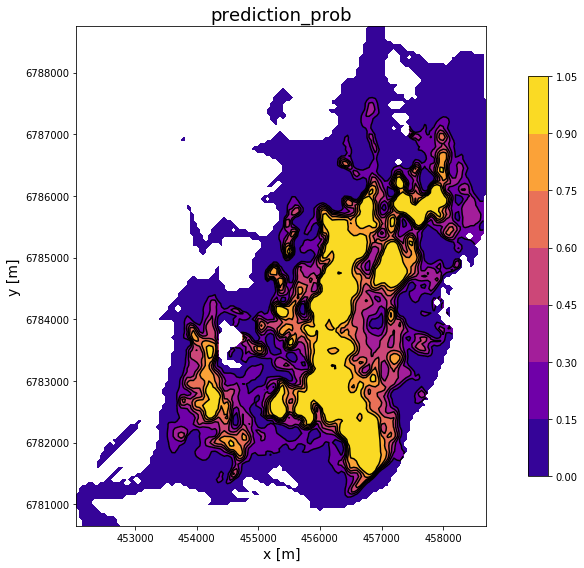

In [20]:
sampleA = dataframes_with_predictions[13]
ssp.plot_map(sampleA, 'prediction_prob')

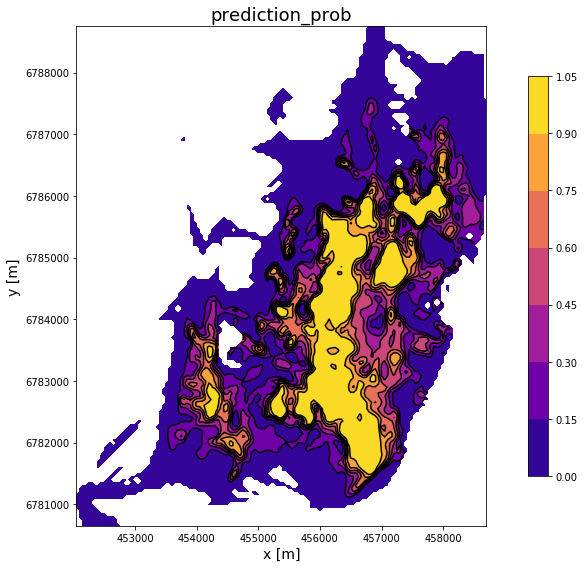

In [21]:
sampleB = dataframes_with_predictions[211]
ssp.plot_map(sampleB, 'prediction_prob')

In [22]:
# Make and output summary dataframes
grouped = pd.concat(dataframes_with_predictions, axis='index').groupby(['XPos', 'YPos'])
df_median = grouped.median()
df_unc = grouped.agg(lambda x: x.quantile(0.9) - x.quantile(0.1))
df_median.rename(columns={'prediction_prob': 'Prediction_Median'}, inplace=True)
df_unc.rename(columns={'prediction_prob': 'Prediction_Uncertainty'}, inplace=True)
df_median.to_csv('PredictionSummary_Median.csv')
df_unc.to_csv('PredictionSummary_Uncertainty.csv')